# 📈 Week 15: Attention Mechanisms & Transformers for Finance

---

## 🎯 Learning Objectives

**By the end of this week, you will understand:**
1. Attention mechanism fundamentals
2. Self-attention and multi-head attention
3. Transformer architecture
4. Temporal Fusion Transformer for forecasting
5. Applications in financial time series

---

## 📚 Why Attention for Finance?

Traditional sequence models (LSTM/GRU) process data sequentially. **Attention** allows models to:
- Focus on relevant time periods
- Capture long-range dependencies efficiently
- Process sequences in parallel
- Interpret which features matter when

---

---

## 📖 Section 1: Attention Mechanism Basics

### 1.1 The Attention Concept

**Intuition:** When predicting tomorrow's price, some past days matter more than others.

**Attention answers:** "How much should I focus on each past observation?"

### 1.2 Attention Formulation

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- **Q (Query):** What we're looking for
- **K (Key):** What we're comparing against
- **V (Value):** The actual information
- **$d_k$:** Dimension of keys (for scaling)

### 1.3 Self-Attention

In self-attention, Q, K, V all come from the same sequence:
- Each position attends to all positions
- Learns relative importance of different time steps

---

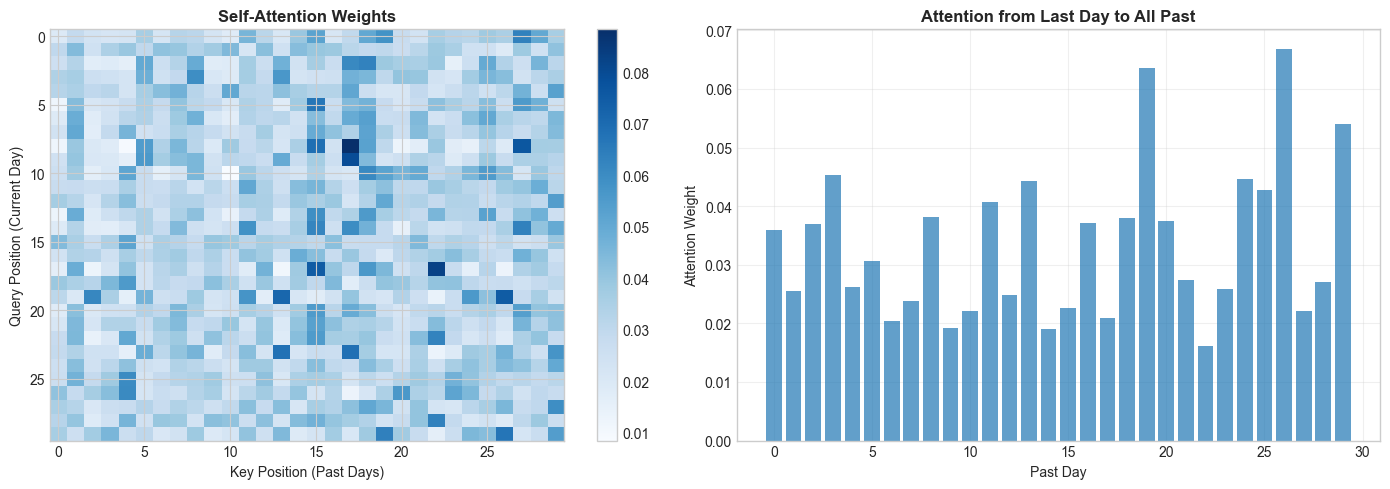

✅ Self-attention computed successfully


In [1]:
# ============================================================
# ATTENTION MECHANISM DEMONSTRATION
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

plt.style.use('seaborn-v0_8-whitegrid')

def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute scaled dot-product attention.
    
    Args:
        Q: Queries (batch, seq_len, d_k)
        K: Keys (batch, seq_len, d_k)
        V: Values (batch, seq_len, d_v)
        mask: Optional attention mask
    
    Returns:
        output: Attended values
        attention_weights: Attention distribution
    """
    d_k = Q.size(-1)
    
    # Compute attention scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)
    
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # Softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Apply attention to values
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights

# Example: Financial time series attention
torch.manual_seed(42)
seq_len = 30  # 30 days of data
d_model = 16

# Simulated price features
X = torch.randn(1, seq_len, d_model)

# Create Q, K, V (in self-attention, all from same source)
W_q = nn.Linear(d_model, d_model)
W_k = nn.Linear(d_model, d_model)
W_v = nn.Linear(d_model, d_model)

Q = W_q(X)
K = W_k(X)
V = W_v(X)

output, attn_weights = scaled_dot_product_attention(Q, K, V)

# Visualize attention weights
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
im = ax1.imshow(attn_weights[0].detach().numpy(), cmap='Blues', aspect='auto')
ax1.set_xlabel('Key Position (Past Days)')
ax1.set_ylabel('Query Position (Current Day)')
ax1.set_title('Self-Attention Weights', fontweight='bold')
plt.colorbar(im, ax=ax1)

ax2 = axes[1]
# Show attention for last position (predicting next day)
last_attn = attn_weights[0, -1].detach().numpy()
ax2.bar(range(seq_len), last_attn, alpha=0.7)
ax2.set_xlabel('Past Day')
ax2.set_ylabel('Attention Weight')
ax2.set_title('Attention from Last Day to All Past', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Self-attention computed successfully")

---

## 📖 Section 2: Multi-Head Attention

### 2.1 Why Multiple Heads?

Single attention captures one type of relationship. **Multiple heads** capture:
- Short-term momentum
- Long-term trends
- Volatility patterns
- Seasonal effects

### 2.2 Multi-Head Attention

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

Where each head:
$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

---

In [2]:
# ============================================================
# MULTI-HEAD ATTENTION
# ============================================================

class MultiHeadAttention(nn.Module):
    """Multi-Head Attention for financial time series."""
    
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    def split_heads(self, x, batch_size):
        """Split into multiple heads."""
        x = x.view(batch_size, -1, self.num_heads, self.d_k)
        return x.transpose(1, 2)  # (batch, heads, seq, d_k)
    
    def forward(self, x, mask=None):
        batch_size = x.size(0)
        
        # Linear projections
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Split into heads
        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)
        
        # Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, V)
        
        # Concat heads
        context = context.transpose(1, 2).contiguous()
        context = context.view(batch_size, -1, self.d_model)
        
        # Final projection
        output = self.W_o(context)
        
        return output, attn_weights

# Test multi-head attention
mha = MultiHeadAttention(d_model=32, num_heads=4)
X = torch.randn(2, 30, 32)  # batch=2, seq=30, features=32
output, weights = mha(X)

print(f"Input shape: {X.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {weights.shape}")
print("✅ Multi-head attention working")

Input shape: torch.Size([2, 30, 32])
Output shape: torch.Size([2, 30, 32])
Attention weights shape: torch.Size([2, 4, 30, 30])
✅ Multi-head attention working


---

## 📖 Section 3: Transformer Architecture

### 3.1 Transformer Components

```
┌─────────────────────────────────────────┐
│         Positional Encoding             │
└───────────────────┬─────────────────────┘
                    │
┌───────────────────▼─────────────────────┐
│     Multi-Head Self-Attention           │
├─────────────────────────────────────────┤
│           Add & Norm                    │
├─────────────────────────────────────────┤
│        Feed-Forward Network             │
├─────────────────────────────────────────┤
│           Add & Norm                    │
└───────────────────┬─────────────────────┘
                    │
                    ▼
              [Repeat N×]
```

### 3.2 Positional Encoding

Transformers have no inherent sense of order. We add positional information:

$$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d})$$
$$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d})$$

---

In [3]:
# ============================================================
# TRANSFORMER FOR TIME SERIES
# ============================================================

class PositionalEncoding(nn.Module):
    """Add positional information to embeddings."""
    
    def __init__(self, d_model, max_len=500):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerBlock(nn.Module):
    """Single Transformer encoder block."""
    
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Self-attention with residual
        attn_out, _ = self.attention(x, mask)
        x = self.norm1(x + self.dropout(attn_out))
        
        # Feed-forward with residual
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        
        return x

class TimeSeriesTransformer(nn.Module):
    """Transformer for financial time series prediction."""
    
    def __init__(self, input_dim, d_model=64, num_heads=4, num_layers=2, 
                 d_ff=256, max_len=500, dropout=0.1, num_classes=2):
        super().__init__()
        
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.output_layer = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Project input
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.dropout(x)
        
        # Transformer blocks
        for block in self.transformer_blocks:
            x = block(x, mask)
        
        # Use last position for prediction
        x = x[:, -1, :]
        
        return self.output_layer(x)

# Test
model = TimeSeriesTransformer(input_dim=10, d_model=32, num_heads=4, num_layers=2)
X = torch.randn(8, 30, 10)  # batch=8, seq=30, features=10
output = model(X)

print(f"Transformer output shape: {output.shape}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print("✅ Time Series Transformer working")

Transformer output shape: torch.Size([8, 2])
Parameters: 42,466
✅ Time Series Transformer working


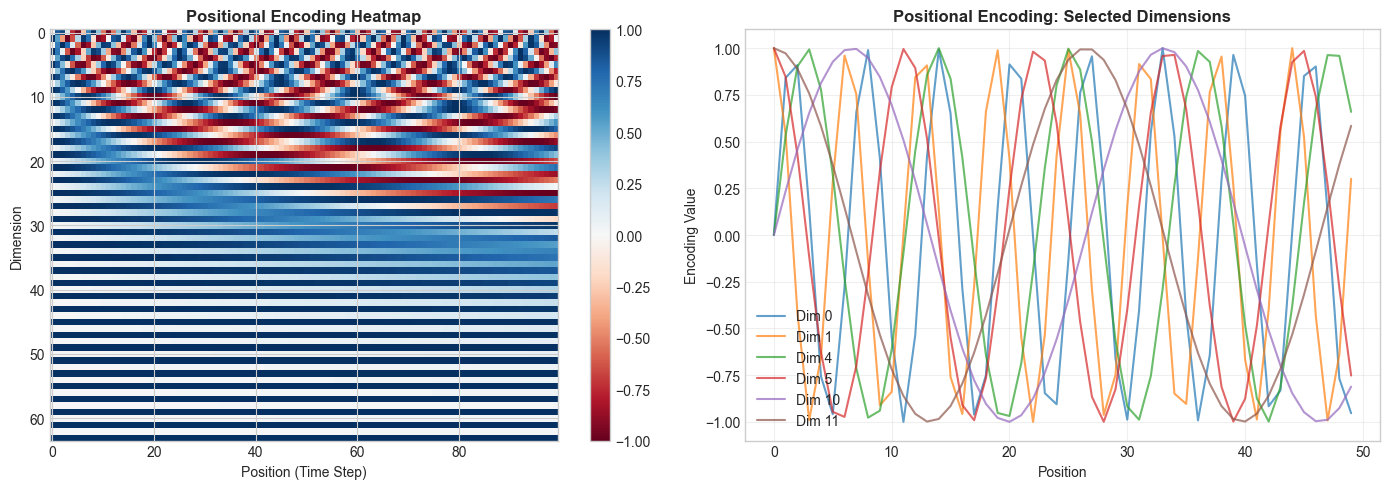

In [4]:
# ============================================================
# VISUALIZE POSITIONAL ENCODING
# ============================================================

pe = PositionalEncoding(d_model=64)
positions = pe.pe[0, :100, :].numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
ax1 = axes[0]
im = ax1.imshow(positions.T, aspect='auto', cmap='RdBu')
ax1.set_xlabel('Position (Time Step)')
ax1.set_ylabel('Dimension')
ax1.set_title('Positional Encoding Heatmap', fontweight='bold')
plt.colorbar(im, ax=ax1)

# Selected dimensions
ax2 = axes[1]
for dim in [0, 1, 4, 5, 10, 11]:
    ax2.plot(positions[:50, dim], label=f'Dim {dim}', alpha=0.7)
ax2.set_xlabel('Position')
ax2.set_ylabel('Encoding Value')
ax2.set_title('Positional Encoding: Selected Dimensions', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 📖 Section 4: Practical Implementation Tips

### 4.1 Causal Masking for Prediction

For financial prediction, we need **causal** (look-ahead) masking:
- Position $t$ can only attend to positions $\leq t$
- Prevents information leakage from future

### 4.2 Best Practices for Financial Transformers

| Practice | Why |
|----------|-----|
| Use causal masking | Prevent look-ahead bias |
| Normalize features | Attention is scale-sensitive |
| Add time features | Capture seasonality |
| Smaller models | Avoid overfitting on small data |
| Regularization | Dropout, weight decay |

### 4.3 Transformer vs LSTM

| Aspect | Transformer | LSTM |
|--------|-------------|------|
| Parallelization | Full | Sequential |
| Long dependencies | Excellent | Good |
| Training speed | Faster | Slower |
| Interpretability | Attention weights | Hidden states |
| Data requirements | More | Less |

---

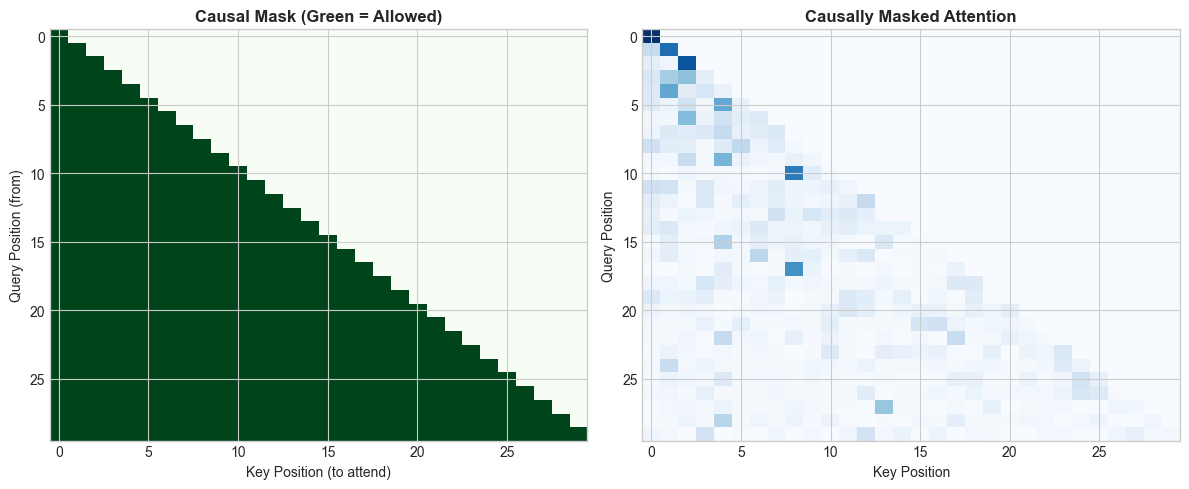

✅ Causal masking ensures no look-ahead bias


In [5]:
# ============================================================
# CAUSAL MASK DEMONSTRATION
# ============================================================

def create_causal_mask(seq_len):
    """Create causal (look-ahead) mask."""
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    return mask == 0  # True where attention is allowed

# Visualize
mask = create_causal_mask(30)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
ax1.imshow(mask.numpy(), cmap='Greens', aspect='auto')
ax1.set_xlabel('Key Position (to attend)')
ax1.set_ylabel('Query Position (from)')
ax1.set_title('Causal Mask (Green = Allowed)', fontweight='bold')

# With masked attention
ax2 = axes[1]
torch.manual_seed(42)
Q = torch.randn(1, 30, 16)
K = torch.randn(1, 30, 16)
V = torch.randn(1, 30, 16)

# Compute scores
scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(16)
scores = scores.masked_fill(~mask.unsqueeze(0), -1e9)
attn_weights = F.softmax(scores, dim=-1)

ax2.imshow(attn_weights[0].detach().numpy(), cmap='Blues', aspect='auto')
ax2.set_xlabel('Key Position')
ax2.set_ylabel('Query Position')
ax2.set_title('Causally Masked Attention', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Causal masking ensures no look-ahead bias")

---

## 📚 Section 5: Key Takeaways

### What You Learned:

1. **Attention** lets models focus on relevant time periods
2. **Self-attention** captures relationships within a sequence
3. **Multi-head attention** captures multiple types of patterns
4. **Transformers** process sequences in parallel with attention
5. **Causal masking** prevents information leakage

### Financial Applications:

- **Return prediction:** Attend to relevant market regimes
- **Volatility forecasting:** Focus on recent turbulent periods
- **Risk assessment:** Identify correlated stress events
- **Portfolio allocation:** Dynamic attention to asset relationships

---

## 📖 References

1. Vaswani et al. (2017) - "Attention Is All You Need"
2. Lim et al. (2021) - "Temporal Fusion Transformers"
3. Wu et al. (2020) - "Deep Transformer Models for Time Series"

---